# Wine Reviews — Text Classification (Improved Notebook)

## Imports

In [39]:
import warnings, os, sys, math, json, random, itertools, datetime as dt

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, f1_score,
    precision_recall_fscore_support, precision_recall_curve, average_precision_score
)

from xgboost import XGBClassifier

from xgboost import XGBClassifier

import wine_preprocessing_utils
import wine_modeling_utils

## Config

In [2]:
warnings.filterwarnings("ignore")

## Global Variables

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

METRICS = []

text_col = "WINE_INPUT_DESCRIPTION"
target_col = "WINE_LABEL_VARIETY"

CV_VALIDATION_PCT = HOLDOUT_PCT = 0.3
TOTAL_TRAINING_PCT = 1-HOLDOUT_PCT
CV_TRAIN_PCT = 1-CV_VALIDATION_PCT

## Load Data

In [4]:
DATA_DIRECTORY = "./data"

df = pd.read_csv(f"{DATA_DIRECTORY}/wine_reviews.csv", 
                    sep=',',
                    quotechar="'",
                    escapechar='\\'
                )

old_names = df.columns.tolist()
new_names = ["INPUT_" + name for name in old_names[:-1]] + ["LABEL_" + old_names[-1]]
new_names = ["WINE_" + name.upper() for name in new_names]

df.columns = new_names
df.head()

,WINE_INPUT_COUNTRY,WINE_INPUT_DESCRIPTION,WINE_INPUT_POINTS,WINE_INPUT_PRICE,WINE_INPUT_PROVINCE,WINE_LABEL_VARIETY
0,US,"This is a tight, black-fruited wine, with gene...",92,28.0,Washington,Cabernet Franc
1,US,A nice starter Pinot for the price. Will intro...,86,14.0,California,Pinot Noir
2,Spain,Raw aromas of rhubarb and scratchy raspberry o...,83,15.0,Northern Spain,Tempranillo
3,Germany,This wine comes out of the bottle a little cra...,90,18.0,Mosel-Saar-Ruwer,Riesling
4,South Africa,Winemaker: Jacques Borman. There's a ton of he...,90,?,Stellenbosch,Shiraz


## Initial EDA

### Null count
Initial there would seem to be no nulls, however, we have observed that there are features with values '?' which for our purpose count as null.

In [5]:
print("Proper Nulls")
display(df.isna().sum().sort_values(ascending=False).head(20))

print()

print("? as Null")
display((df=='?').sum().sort_values(ascending=False).head(20))

Proper Nulls


WINE_INPUT_COUNTRY        0
WINE_INPUT_DESCRIPTION    0
WINE_INPUT_POINTS         0
WINE_INPUT_PRICE          0
WINE_INPUT_PROVINCE       0
WINE_LABEL_VARIETY        0
dtype: int64


? as Null


WINE_INPUT_PRICE          5578
WINE_INPUT_COUNTRY          33
WINE_INPUT_PROVINCE         33
WINE_INPUT_DESCRIPTION       0
WINE_INPUT_POINTS            0
WINE_LABEL_VARIETY           0
dtype: int64

### Class distribution

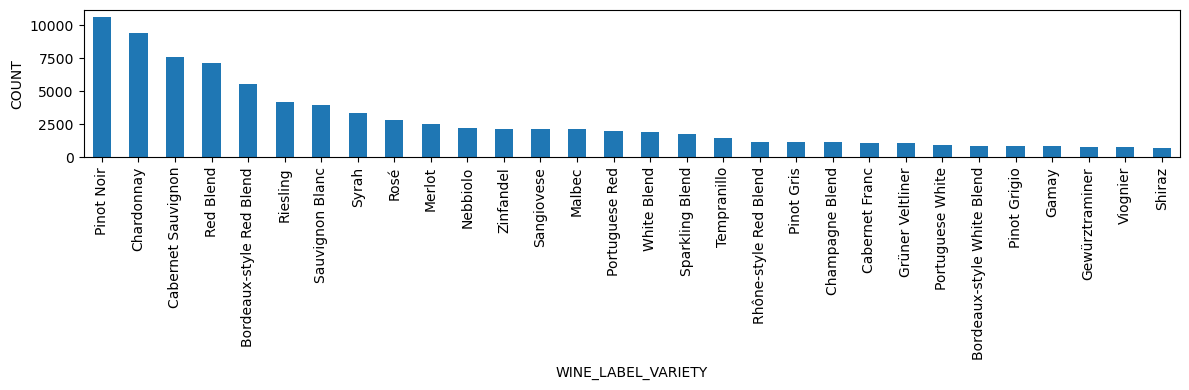

In [6]:
#class_counts = df[target_col].value_counts(dropna=False).reset_index()
#display(class_counts.head(20))
#print(f"Unique classes: {class_counts.shape[0]}")

figure, axis = plt.subplots(figsize=(12, 4))

df[target_col].value_counts().plot(
    kind='bar',
    ax=axis,
    rot=90)

axis.set_ylabel('COUNT')
plt.tight_layout()
plt.show()

## Data Prepatation

In [7]:
# Clean up the price column
df["WINE_INPUT_PRICE"] = df["WINE_INPUT_PRICE"].str.replace("?", "")
df["WINE_INPUT_PRICE"] = pd.to_numeric(df["WINE_INPUT_PRICE"])
df["WINE_INPUT_PRICE_NULL_FLAG"] = df["WINE_INPUT_PRICE"].isna()

In [8]:
# Replace the country names with their respective country codes
orig_country_column = 'WINE_INPUT_COUNTRY'
code_column = "WINE_INPUT_COUNTRY_CODE"
df[code_column] = df[orig_country_column].apply(wine_preprocessing_utils.country_to_code)
df = df.drop(orig_country_column, axis=1)

In [9]:
# We assign a specific code to the missing values of province
df["WINE_INPUT_PROVINCE"] = df["WINE_INPUT_PROVINCE"].str.replace("?", "UNK")

In [10]:
df.head()

,WINE_INPUT_DESCRIPTION,WINE_INPUT_POINTS,WINE_INPUT_PRICE,WINE_INPUT_PROVINCE,WINE_LABEL_VARIETY,WINE_INPUT_PRICE_NULL_FLAG,WINE_INPUT_COUNTRY_CODE
0,"This is a tight, black-fruited wine, with gene...",92,28.0,Washington,Cabernet Franc,False,US
1,A nice starter Pinot for the price. Will intro...,86,14.0,California,Pinot Noir,False,US
2,Raw aromas of rhubarb and scratchy raspberry o...,83,15.0,Northern Spain,Tempranillo,False,ES
3,This wine comes out of the bottle a little cra...,90,18.0,Mosel-Saar-Ruwer,Riesling,False,DE
4,Winemaker: Jacques Borman. There's a ton of he...,90,NaN,Stellenbosch,Shiraz,True,ZA


In [11]:
# Recheck nulls
print("Proper Nulls")
display(df.isna().sum().sort_values(ascending=False).head(20))

print()

print("? as Null")
display((df=='?').sum().sort_values(ascending=False).head(20))

Proper Nulls


WINE_INPUT_PRICE              5578
WINE_INPUT_DESCRIPTION           0
WINE_INPUT_POINTS                0
WINE_INPUT_PROVINCE              0
WINE_LABEL_VARIETY               0
WINE_INPUT_PRICE_NULL_FLAG       0
WINE_INPUT_COUNTRY_CODE          0
dtype: int64


? as Null


WINE_INPUT_DESCRIPTION        0
WINE_INPUT_POINTS             0
WINE_INPUT_PRICE              0
WINE_INPUT_PROVINCE           0
WINE_LABEL_VARIETY            0
WINE_INPUT_PRICE_NULL_FLAG    0
WINE_INPUT_COUNTRY_CODE       0
dtype: int64

## Secondary EDA

We create a temporary mapping to analyze what type of wine the variety belongs to, however, we cannot use this as a feature for our model, given that in reality we would not have this column available for us, because it is derived from the label. That said, this column could be useful if instead we wanted to change our target variable, and predict on the 3 categories only instead of the 29 categories that currently exist. This label rethinking will not be performed for this project deliverable, but can be considered for further deliverables.

In [12]:
wine_type_map = {
    # Red wines
    'Cabernet Franc': 'Red',
    'Pinot Noir': 'Red',
    'Tempranillo': 'Red',
    'Shiraz': 'Red',
    'Sangiovese': 'Red',
    'Malbec': 'Red',
    'Cabernet Sauvignon': 'Red',
    'Red Blend': 'Red',
    'Bordeaux-style Red Blend': 'Red',
    'Nebbiolo': 'Red',
    'Merlot': 'Red',
    'Rhône-style Red Blend': 'Red',
    'Portuguese Red': 'Red',
    'Zinfandel': 'Red',
    'Syrah': 'Red',
    'Gamay': 'Red',

    # White wines
    'Riesling': 'White',
    'Pinot Gris': 'White',
    'Chardonnay': 'White',
    'Grüner Veltliner': 'White',
    'Sauvignon Blanc': 'White',
    'Bordeaux-style White Blend': 'White',
    'Gewürztraminer': 'White',
    'White Blend': 'White',
    'Viognier': 'White',
    'Pinot Grigio': 'White',
    'Portuguese White': 'White',

    # Other types
    'Sparkling Blend': 'Other',
    'Rosé': 'Other',
    'Champagne Blend': 'Other',
}

df_tmp = df.copy()
df_tmp["WINE_LABEL_TYPE"] = df_tmp[target_col].map(wine_type_map)
df_tmp.head()

,WINE_INPUT_DESCRIPTION,WINE_INPUT_POINTS,WINE_INPUT_PRICE,WINE_INPUT_PROVINCE,WINE_LABEL_VARIETY,WINE_INPUT_PRICE_NULL_FLAG,WINE_INPUT_COUNTRY_CODE,WINE_LABEL_TYPE
0,"This is a tight, black-fruited wine, with gene...",92,28.0,Washington,Cabernet Franc,False,US,Red
1,A nice starter Pinot for the price. Will intro...,86,14.0,California,Pinot Noir,False,US,Red
2,Raw aromas of rhubarb and scratchy raspberry o...,83,15.0,Northern Spain,Tempranillo,False,ES,Red
3,This wine comes out of the bottle a little cra...,90,18.0,Mosel-Saar-Ruwer,Riesling,False,DE,White
4,Winemaker: Jacques Borman. There's a ton of he...,90,NaN,Stellenbosch,Shiraz,True,ZA,Red


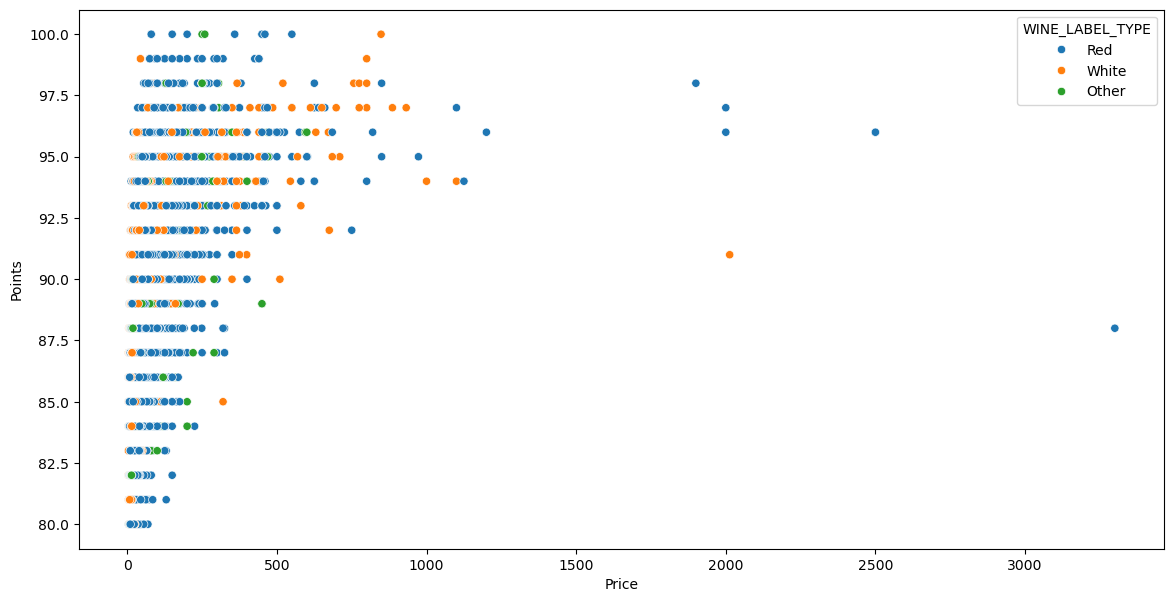

In [13]:
plt.figure(figsize=(14,7))
sns.scatterplot(data=df_tmp, x="WINE_INPUT_PRICE", y="WINE_INPUT_POINTS", hue="WINE_LABEL_TYPE")
plt.xlabel("Price")
plt.ylabel("Points");

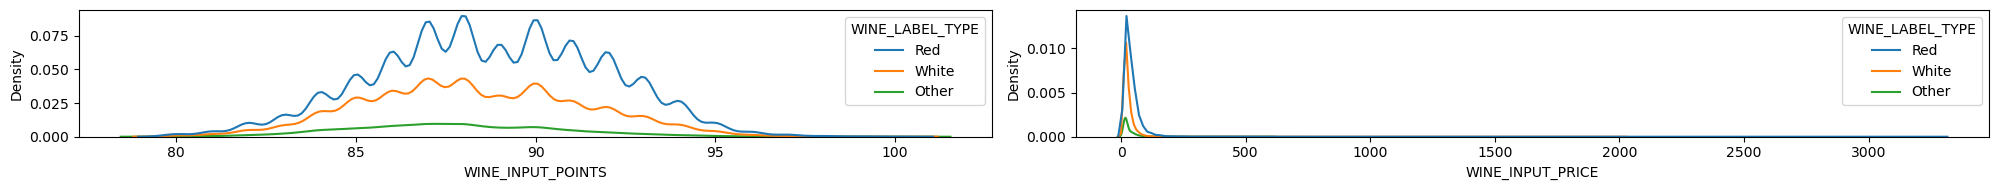

In [14]:
num_cols = df_tmp.select_dtypes(include=np.number).columns

plot_cols = 2
plot_rows = int(np.ceil((len(num_cols)/plot_cols)))

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(20, plot_cols * plot_rows))
ax = ax.flatten()

for i, col in enumerate(num_cols):
    sns.kdeplot(data=df_tmp, x=col, hue="WINE_LABEL_TYPE", ax=ax[i])

plt.tight_layout()

## Holdout split

In [33]:
# We create a split in our data where we will create a holdout which will contain 30% of all rows for each class, so that we can measure the final results after crossvalidation and experimentation.
df_training, df_holdout = train_test_split(
                                df,
                                test_size=HOLDOUT_PCT,
                                stratify=df[target_col],
                                random_state=42
)

print(f"Training shape: {df_training.shape}")
print(f"Holdout shape: {df_holdout.shape}")

Training shape: (58886, 7)
Holdout shape: (25237, 7)


In [30]:
df_holdout.head()

,WINE_INPUT_DESCRIPTION,WINE_INPUT_POINTS,WINE_INPUT_PRICE,WINE_INPUT_PROVINCE,WINE_LABEL_VARIETY,WINE_INPUT_PRICE_NULL_FLAG,WINE_INPUT_COUNTRY_CODE
40123,A rich wine with great fruits as well as struc...,94,129.0,Burgundy,Pinot Noir,False,FR
70767,"Sweet and easygoing from the start, with candi...",88,12.0,Mendoza Province,Malbec,False,AR
81456,"Creamy and crisp, this slowly reveals delicate...",90,60.0,Northeastern Italy,Sparkling Blend,False,IT
789,Complex and slightly austere flavors like rhub...,92,52.0,California,Pinot Noir,False,US
19543,"Delicious and exotic, with raspberry, cherry, ...",90,38.0,California,Pinot Noir,False,US


## First Iteration

In [16]:
step = "Baseline"

df_training_iter1 = df_training.copy().drop("WINE_INPUT_DESCRIPTION", axis=1)
df_training_iter1

,WINE_INPUT_POINTS,WINE_INPUT_PRICE,WINE_INPUT_PROVINCE,WINE_LABEL_VARIETY,WINE_INPUT_PRICE_NULL_FLAG,WINE_INPUT_COUNTRY_CODE
11574,93,NaN,Burgundy,Chardonnay,True,FR
58125,89,35.0,California,Chardonnay,False,US
64247,90,25.0,California,Pinot Noir,False,US
83997,92,40.0,Burgundy,Chardonnay,False,FR
26931,89,NaN,Douro,Portuguese Red,True,PT
...,...,...,...,...,...,...
20490,88,29.0,Washington,Bordeaux-style Red Blend,False,US
25790,87,21.0,Northern Spain,Tempranillo,False,ES
84101,87,40.0,California,Cabernet Sauvignon,False,US
82436,90,21.0,Provence,Rosé,False,FR


### Experiments

#### Logistic Regression

In [ ]:
log_reg_params=[
                {"max_iter": 100}, 
                {"max_iter": 500},
                {"max_iter": 1000}
            ]
cv_seeds = [0, 1, 7, 42]
lr_experiment_details, lr_fold_validation_results = wine_modeling_utils.prepare_and_run_cv_baseline(
                                df=df_training_iter1, 
                                model_type="LOGISTIC_REGRESSION",
                                lbl_column=target_col,
                                cv_validation_pct=0.3,
                                cv_seeds=cv_seeds,
                                log_reg_params=log_reg_params
                    )

20251109 19:55:06 - Training for 1th fold out of 4.
Train rows: 41220
Test rows: 17666
  2025/11/09 19:55:08 - Training 1th model out of 3
  2025/11/09 19:55:17 - Duration: 0:00:09.278096.
  2025/11/09 19:55:17 - Training 2th model out of 3
  2025/11/09 19:55:39 - Duration: 0:00:21.298460.
  2025/11/09 19:55:39 - Training 3th model out of 3
  2025/11/09 19:56:00 - Duration: 0:00:21.407340.
20251109 19:56:00 - Training for 2th fold out of 4.
Train rows: 41220
Test rows: 17666
  2025/11/09 19:56:02 - Training 1th model out of 3
  2025/11/09 19:56:11 - Duration: 0:00:09.039725.
  2025/11/09 19:56:11 - Training 2th model out of 3
  2025/11/09 19:56:28 - Duration: 0:00:17.206651.
  2025/11/09 19:56:28 - Training 3th model out of 3
  2025/11/09 19:56:48 - Duration: 0:00:20.213135.
20251109 19:56:48 - Training for 3th fold out of 4.
Train rows: 41220
Test rows: 17666
  2025/11/09 19:56:50 - Training 1th model out of 3
  2025/11/09 19:57:01 - Duration: 0:00:10.543314.
  2025/11/09 19:57:01 - T

In [ ]:
transformed = {}

for i in range(len(lr_fold_validation_results[0])):
    key = list(lr_fold_validation_results[0][i].keys())[0]
    vals = [list(d[i].values())[0] for d in lr_fold_validation_results]
    transformed[key] = vals
transformed

for fold_vals in transformed.values():
    a = np.array(fold_vals)[:, :-1].mean(axis=0)
    print(a)

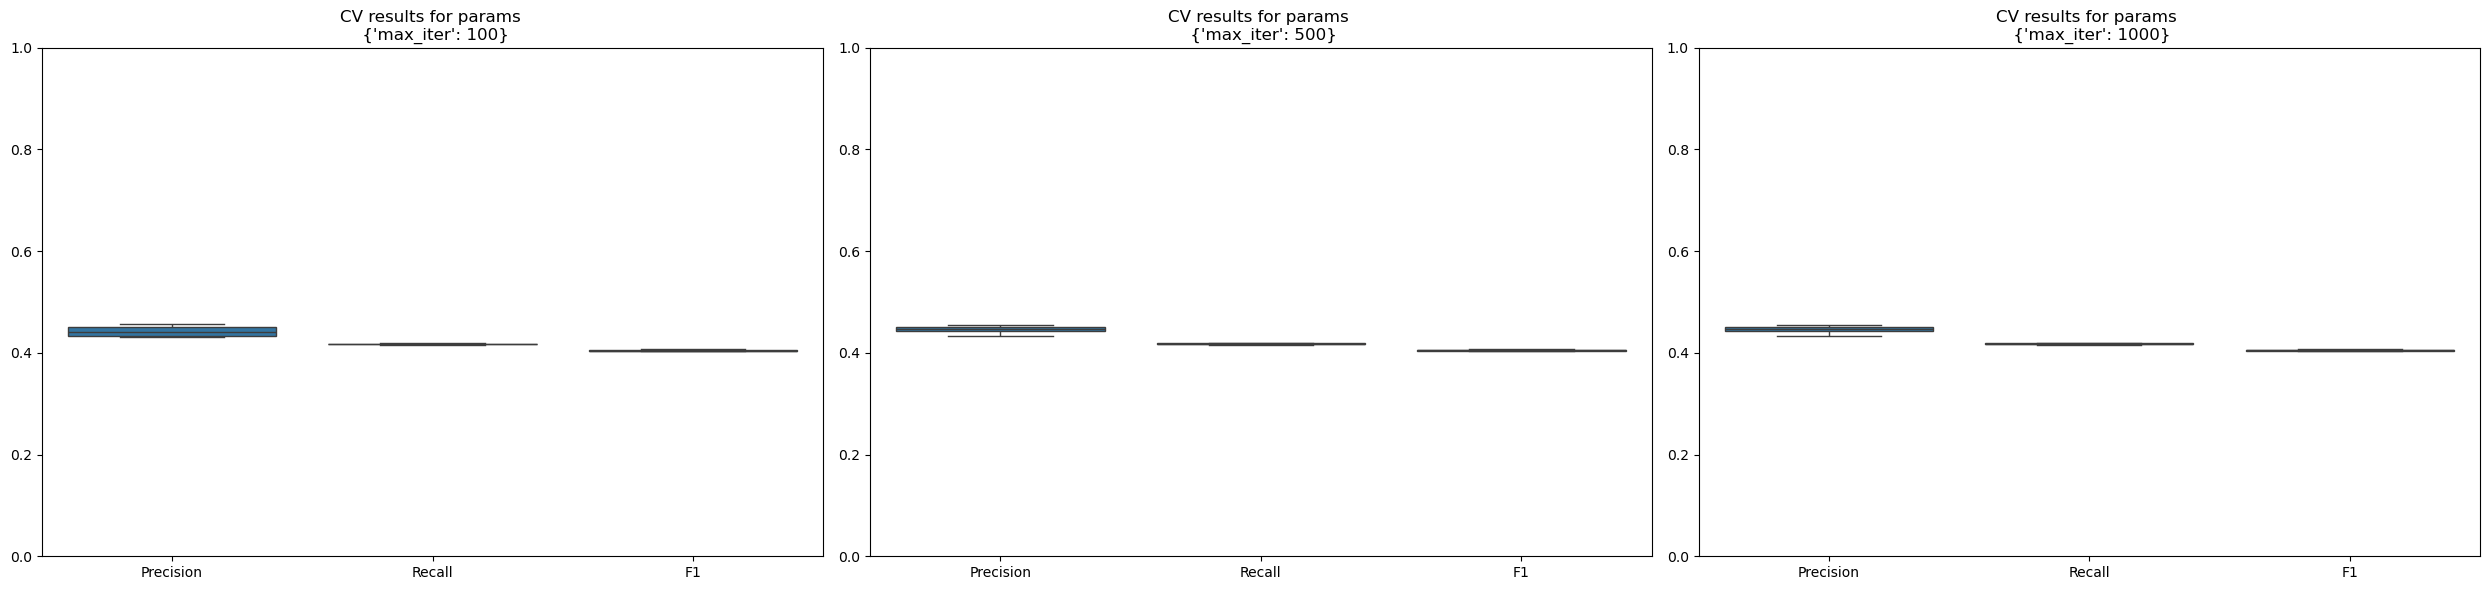

In [18]:
fig, ax = plt.subplots(1, len(transformed.keys()), figsize=(25, 6))

for idx, t in enumerate(transformed.items()):
    params, fold_results = t
    #plt.figure()
    a = np.array(fold_results)
    df_metrics = pd.DataFrame(a).loc[:, [0,1,2]]
    df_metrics.columns = ["Precision", "Recall", "F1"]
    sns.boxplot(df_metrics, ax=ax[idx])
    ax[idx].title.set_text(f"CV results for params \n {params}")
    ax[idx].set_ylim(0.0, 1.0)
    ax[idx].grid()
plt.tight_layout()

#### XGB Classifier

In [ ]:
xgb_classifier_params=[
            {"eta": 0.3, "max_depth": 6}, 
            {"eta": 0.01, "max_depth": 6},
            {"eta": 0.3, "max_depth": 4}, 
            {"eta": 0.01, "max_depth": 4}
        ]
cv_seeds = [0, 1, 7]
xgb_experiment_details, xgb_fold_validation_results = wine_modeling_utils.prepare_and_run_cv_baseline(
                                df=df_training_iter1,
                                model_type="XGBC",
                                lbl_column=target_col,
                                cv_validation_pct=0.3,
                                cv_seeds=cv_seeds,
                                xgb_classifier_params=xgb_classifier_params
                    )

20251109 21:05:47 - Training for 1th fold out of 3.
Train rows: 41220
Test rows: 17666
  2025/11/09 21:05:48 - Training 1th model out of 4
  2025/11/09 21:06:04 - Duration: 0:00:15.308438.
  2025/11/09 21:06:04 - Training 2th model out of 4
  2025/11/09 21:06:20 - Duration: 0:00:15.928961.
  2025/11/09 21:06:20 - Training 3th model out of 4
  2025/11/09 21:06:32 - Duration: 0:00:12.411731.
  2025/11/09 21:06:32 - Training 4th model out of 4
  2025/11/09 21:06:45 - Duration: 0:00:12.715021.
20251109 21:06:45 - Training for 2th fold out of 3.
Train rows: 41220
Test rows: 17666
  2025/11/09 21:06:47 - Training 1th model out of 4
  2025/11/09 21:07:02 - Duration: 0:00:15.111232.
  2025/11/09 21:07:02 - Training 2th model out of 4
  2025/11/09 21:07:17 - Duration: 0:00:15.616152.
  2025/11/09 21:07:17 - Training 3th model out of 4
  2025/11/09 21:07:30 - Duration: 0:00:12.590353.
  2025/11/09 21:07:30 - Training 4th model out of 4
  2025/11/09 21:07:43 - Duration: 0:00:12.898454.
20251109 2

In [43]:
transformed = {}

for i in range(len(xgb_fold_validation_results[0])):
    key = list(xgb_fold_validation_results[0][i].keys())[0]
    vals = [list(d[i].values())[0] for d in xgb_fold_validation_results]
    transformed[key] = vals
transformed

for fold_vals in transformed.values():
    a = np.array(fold_vals)[:, :-1].mean(axis=0)
    print(a)

[0.4620019875406 0.43482667003816444 0.43427235934064595]
[0.47555099340377754 0.4395346869808155 0.43075282642214424]
[0.47321709505599413 0.43827625435682677 0.4362252881386257]
[0.46335506119237907 0.43654906000697974 0.42075237030894463]


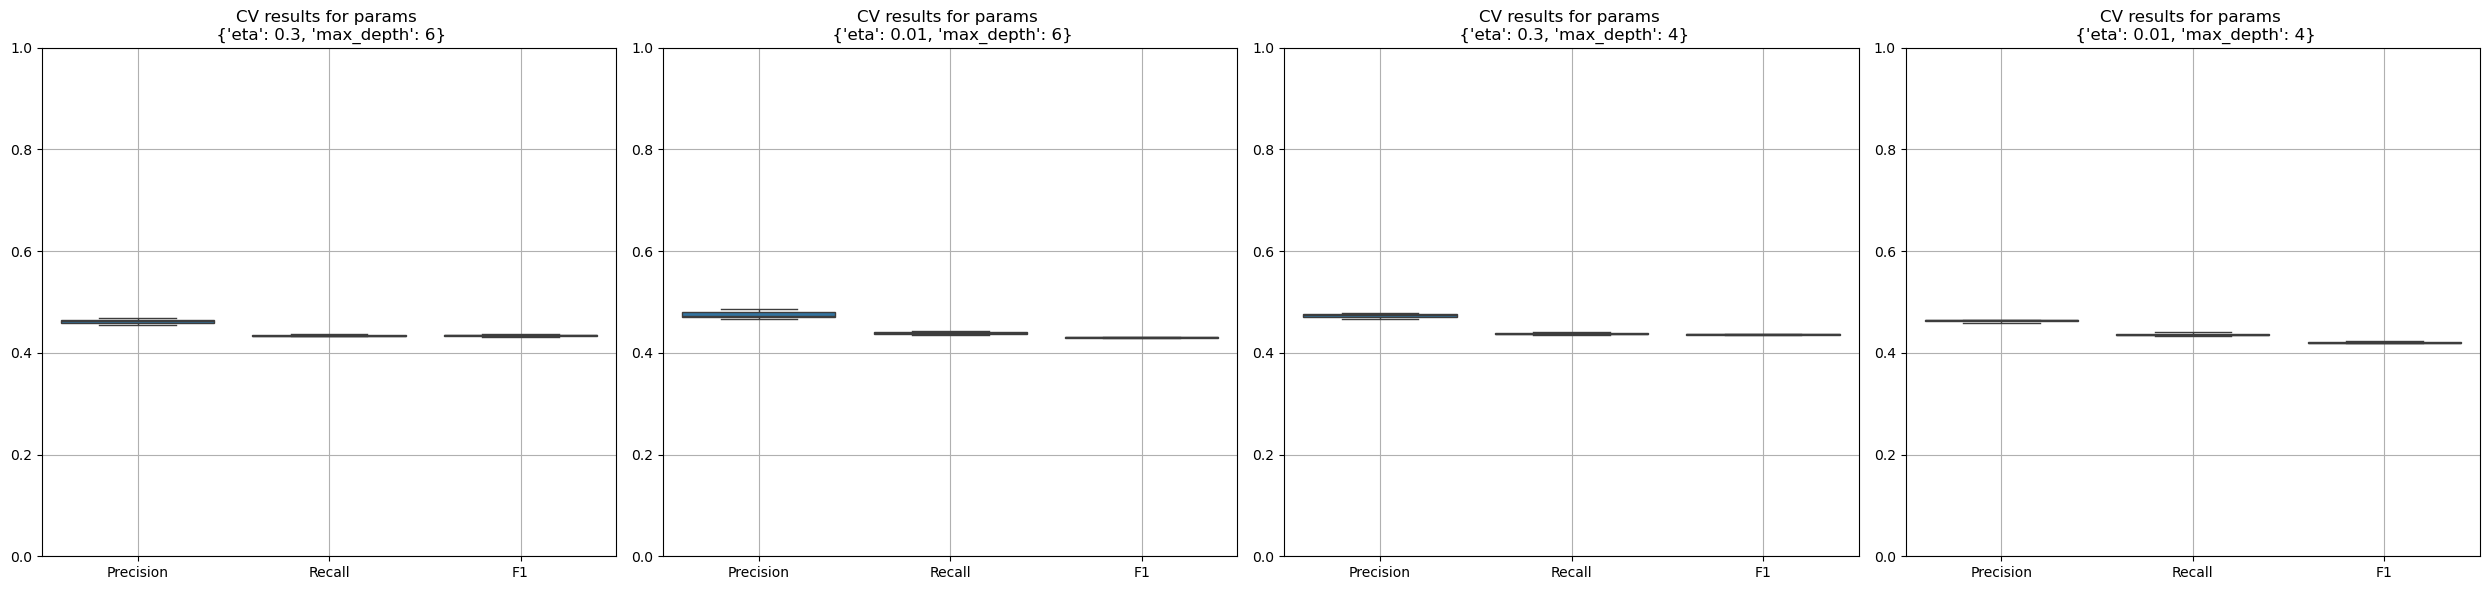

In [44]:
fig, ax = plt.subplots(1, len(transformed.keys()), figsize=(25, 6))

for idx, t in enumerate(transformed.items()):
    params, fold_results = t
    #plt.figure()
    a = np.array(fold_results)
    df_metrics = pd.DataFrame(a).loc[:, [0,1,2]]
    df_metrics.columns = ["Precision", "Recall", "F1"]
    sns.boxplot(df_metrics, ax=ax[idx])
    ax[idx].title.set_text(f"CV results for params \n {params}")
    ax[idx].set_ylim(0.0, 1.0)
    ax[idx].grid()
plt.tight_layout()

#### SVM

In [ ]:
svm_classifier_params=[
            {"kernel": "linear"},
            {"kernel": "poly"}, 
        ]
cv_seeds = [0, 1, 7]
svm_experiment_details, svm_fold_validation_results = wine_modeling_utils.prepare_and_run_cv_baseline(
                                df=df_training_iter1, 
                                model_type="SVMC",
                                lbl_column=target_col,
                                cv_validation_pct=0.3,
                                cv_seeds=cv_seeds,
                                svm_classifier_params=svm_classifier_params
                    )

## Second Iteration

In [35]:
step = "FeatureEngineering"

df_training_iter2 = df_training.copy()
df_training_iter2

,WINE_INPUT_DESCRIPTION,WINE_INPUT_POINTS,WINE_INPUT_PRICE,WINE_INPUT_PROVINCE,WINE_LABEL_VARIETY,WINE_INPUT_PRICE_NULL_FLAG,WINE_INPUT_COUNTRY_CODE
11574,"There is an important element of wood here, al...",93,NaN,Burgundy,Chardonnay,True,FR
58125,This is a successful straight-ahead Chardonnay...,89,35.0,California,Chardonnay,False,US
64247,Thick tannins gird the powerful fruit in this ...,90,25.0,California,Pinot Noir,False,US
83997,"Full of fruit, this also expresses a tight and...",92,40.0,Burgundy,Chardonnay,False,FR
26931,Plenty of Douro tannins and minerality give th...,89,NaN,Douro,Portuguese Red,True,PT
...,...,...,...,...,...,...,...
20490,A two-vintage blend of Cabernet Franc and Malb...,88,29.0,Washington,Bordeaux-style Red Blend,False,US
25790,"Gritty, roasted aromas of herbal black fruits ...",87,21.0,Northern Spain,Tempranillo,False,ES
84101,"Good, classic blackberry, currant, oak and min...",87,40.0,California,Cabernet Sauvignon,False,US
82436,"This blend of Cinsault, Grenache and Syrah is ...",90,21.0,Provence,Rosé,False,FR


### Experiments

#### Logistic Regression

In [17]:
log_reg_params=[
                {"max_iter": 100}, 
                {"max_iter": 500},
                {"max_iter": 1000}
            ]
cv_seeds = [0, 1, 7, 42]
lr_experiment_details, lr_fold_validation_results = wine_modeling_utils.prepare_and_run_cv_feat_eng(
                                df=df_training_iter2, 
                                model_type="LOGISTIC_REGRESSION",
                                lbl_column=target_col,
                                cv_validation_pct=0.3,
                                cv_seeds=cv_seeds,
                                log_reg_params=log_reg_params
                    )

20251110 13:39:03 - Training for 1th fold out of 4.
Train rows: 41220
Test rows: 17666
  2025/11/10 13:39:13 - Training 1th model out of 3
  2025/11/10 13:39:42 - Duration: 0:00:28.557657.
  2025/11/10 13:39:42 - Training 2th model out of 3
  2025/11/10 13:40:52 - Duration: 0:01:10.540409.
  2025/11/10 13:40:52 - Training 3th model out of 3
  2025/11/10 13:42:02 - Duration: 0:01:09.939415.
20251110 13:42:02 - Training for 2th fold out of 4.
Train rows: 41220
Test rows: 17666
  2025/11/10 13:42:12 - Training 1th model out of 3
  2025/11/10 13:42:39 - Duration: 0:00:27.191959.
  2025/11/10 13:42:39 - Training 2th model out of 3
  2025/11/10 13:43:50 - Duration: 0:01:10.960402.
  2025/11/10 13:43:50 - Training 3th model out of 3
  2025/11/10 13:44:59 - Duration: 0:01:08.387588.
20251110 13:44:59 - Training for 3th fold out of 4.
Train rows: 41220
Test rows: 17666
  2025/11/10 13:45:09 - Training 1th model out of 3
  2025/11/10 13:45:38 - Duration: 0:00:29.280006.
  2025/11/10 13:45:38 - T

In [18]:
transformed = {}

for i in range(len(lr_fold_validation_results[0])):
    key = list(lr_fold_validation_results[0][i].keys())[0]
    vals = [list(d[i].values())[0] for d in lr_fold_validation_results]
    transformed[key] = vals
transformed

mean_performances = []
for fold_vals in transformed.values():
    a = np.array(fold_vals)[:, :-1].mean(axis=0)
    print(a)
    mean_performances.append(a)

mean_performances = {k:v for k,v in zip(transformed.keys(), np.array(mean_performances))}
mean_performances

[0.6643195874565615 0.6731895246388755 0.6680103601456098]
[0.6630187018951653 0.6720766099512776 0.666713121733644]
[0.6630187018951653 0.6720766099512776 0.666713121733644]


{"{'max_iter': 100}": array([0.6643195874565615, 0.6731895246388755, 0.6680103601456098],
       dtype=object),
 "{'max_iter': 500}": array([0.6630187018951653, 0.6720766099512776, 0.666713121733644],
       dtype=object),
 "{'max_iter': 1000}": array([0.6630187018951653, 0.6720766099512776, 0.666713121733644],
       dtype=object)}

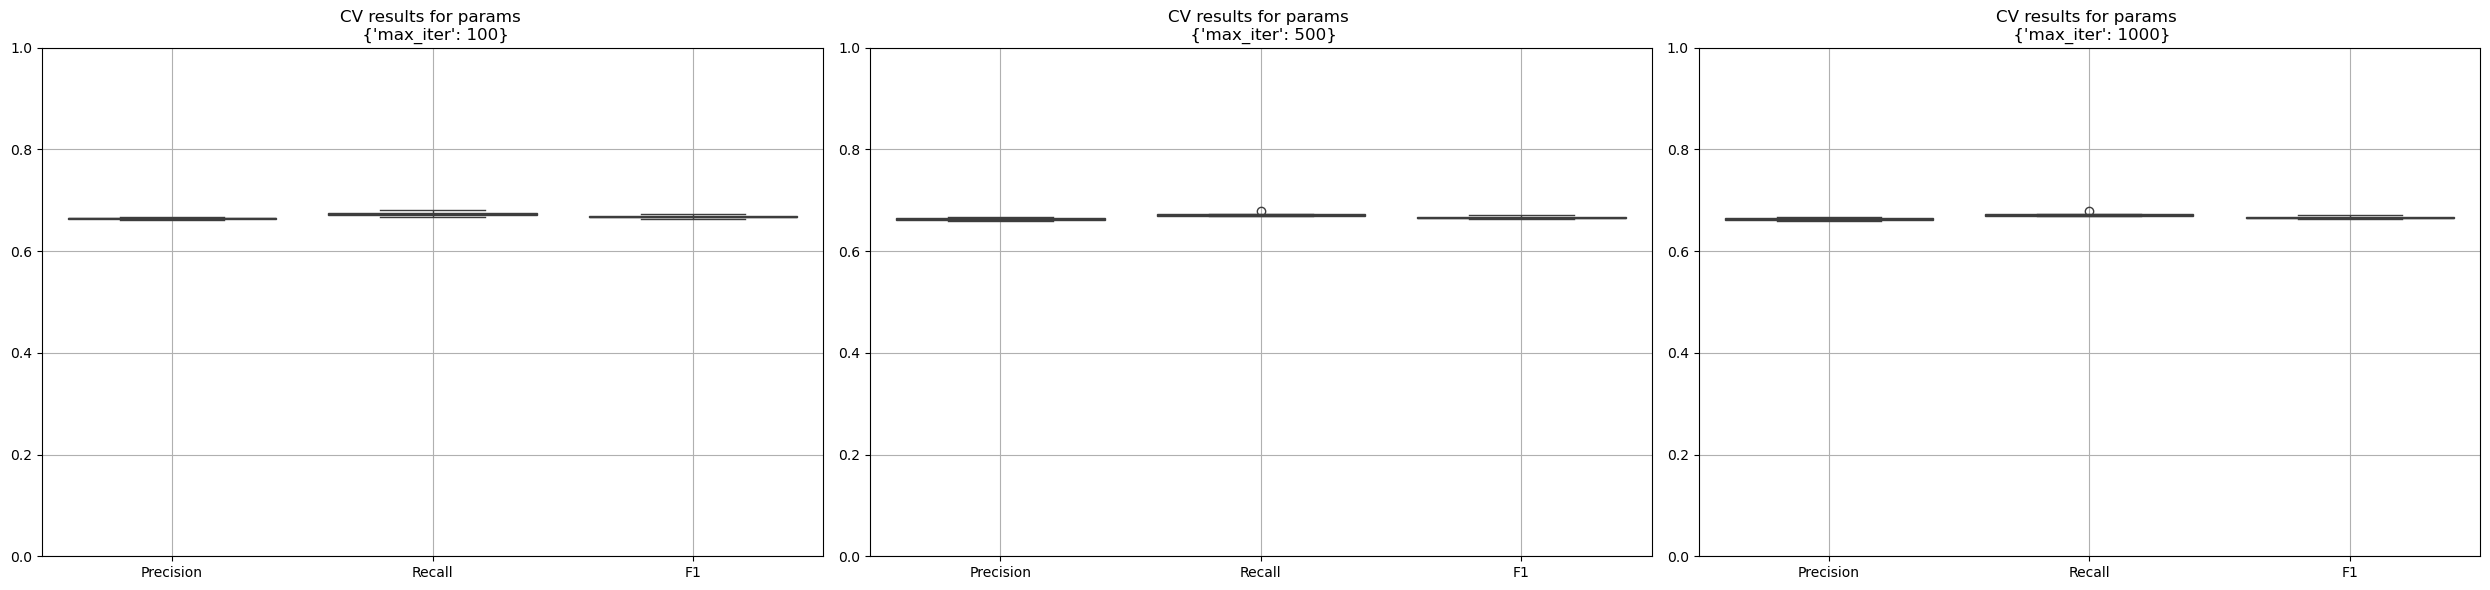

In [19]:
fig, ax = plt.subplots(1, len(transformed.keys()), figsize=(25, 6))

for idx, t in enumerate(transformed.items()):
    params, fold_results = t
    #plt.figure()
    a = np.array(fold_results)
    df_metrics = pd.DataFrame(a).loc[:, [0,1,2]]
    df_metrics.columns = ["Precision", "Recall", "F1"]
    sns.boxplot(df_metrics, ax=ax[idx])
    ax[idx].title.set_text(f"CV results for params \n {params}")
    ax[idx].set_ylim(0.0, 1.0)
    ax[idx].grid()
plt.tight_layout()

##### Best train

In [42]:
seed = 42
model_params = {'max_iter': 100}
lbl_column = target_col
df_holdout_final = df_holdout.copy()
df_train_final = df_training_iter2.copy()

vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=1000, 
        min_df=2, 
        max_df=0.9,
    )

start_fold_time = dt.datetime.now()

X_train_tfidf = vectorizer.fit_transform(df_train_final["WINE_INPUT_DESCRIPTION"])
X_holdout_tfidf = vectorizer.transform(df_holdout_final["WINE_INPUT_DESCRIPTION"])

df_train_final = df_train_final.drop("WINE_INPUT_DESCRIPTION", axis=1)
df_holdout_final = df_holdout_final.drop("WINE_INPUT_DESCRIPTION", axis=1)

train_price_mean_fill_na = df_train_final["WINE_INPUT_PRICE"].mean()
df_train_final["WINE_INPUT_PRICE"] = df_train_final["WINE_INPUT_PRICE"].fillna(train_price_mean_fill_na)
df_holdout["WINE_INPUT_PRICE"] = df_holdout_final["WINE_INPUT_PRICE"].fillna(train_price_mean_fill_na)

X_train, y_train = wine_modeling_utils.get_X_y(df=df_train_final, lbl_col=lbl_column)
X_holdout, y_holdout = wine_modeling_utils.get_X_y(df=df_holdout_final, lbl_col=lbl_column)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_holdout = le.transform(y_holdout)

cat_cols = ["WINE_INPUT_PROVINCE", "WINE_INPUT_COUNTRY_CODE"]
X_train_num = X_train[[c for c in X_train.columns if c not in cat_cols]]
X_holdout_num = X_holdout[[c for c in X_holdout.columns if c not in cat_cols]]

one_hot_enc = OneHotEncoder(handle_unknown='ignore', 
                            sparse_output=False, 
                            drop="first")
X_train_enc = one_hot_enc.fit_transform(X_train[cat_cols])
X_holdout_enc = one_hot_enc.transform(X_holdout[cat_cols])

X_train = np.hstack((X_train_num, X_train_enc, X_train_tfidf.toarray()))
X_holdout = np.hstack((X_holdout_num, X_holdout_enc, X_holdout_tfidf.toarray()))

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_holdout = scaler.transform(X_holdout)


log_reg = LogisticRegression(random_state=seed, 
                             **model_params
)

log_reg.fit(X_train, y_train)

# Make predictions
holdout_y_pred = log_reg.predict(X_holdout)

# Calculate Precision, Recall and F1 score
holdout_prfs = precision_recall_fscore_support(y_holdout, holdout_y_pred, average=None)
holdout_prfs_macro = precision_recall_fscore_support(y_holdout, holdout_y_pred, average="macro")

print(holdout_prfs_macro)

(0.6907164351573023, 0.7000160900237596, 0.6945417141405488, None)


#### XGB Classifier

In [ ]:
xgb_classifier_params=[
            {"eta": 0.3, "max_depth": 6}, 
            {"eta": 0.01, "max_depth": 6},
            {"eta": 0.3, "max_depth": 4}, 
            {"eta": 0.01, "max_depth": 4}
        ]
cv_seeds = [0, 1, 7]
xgb_experiment_details, xgb_fold_validation_results = wine_modeling_utils.prepare_and_run_cv_feat_eng(
                                df=df_training_iter2, 
                                model_type="XGBC",
                                lbl_column=target_col,
                                cv_validation_pct=0.3,
                                cv_seeds=cv_seeds,
                                xgb_classifier_params=xgb_classifier_params
                    )

20251110 14:03:52 - Training for 1th fold out of 3.
Train rows: 41220
Test rows: 17666
  2025/11/10 14:04:03 - Training 1th model out of 4
  2025/11/10 14:08:24 - Duration: 0:04:20.341939.
  2025/11/10 14:08:24 - Training 2th model out of 4
  2025/11/10 14:13:28 - Duration: 0:05:04.196218.
  2025/11/10 14:13:28 - Training 3th model out of 4
  2025/11/10 14:16:54 - Duration: 0:03:25.599367.
  2025/11/10 14:16:54 - Training 4th model out of 4
  2025/11/10 14:20:21 - Duration: 0:03:27.132166.
20251110 14:20:21 - Training for 2th fold out of 3.
Train rows: 41220
Test rows: 17666
  2025/11/10 14:20:30 - Training 1th model out of 4
  2025/11/10 14:25:07 - Duration: 0:04:36.658730.
  2025/11/10 14:25:07 - Training 2th model out of 4


In [ ]:
transformed = {}

for i in range(len(xgb_fold_validation_results[0])):
    key = list(xgb_fold_validation_results[0][i].keys())[0]
    vals = [list(d[i].values())[0] for d in xgb_fold_validation_results]
    transformed[key] = vals
transformed

mean_performances = []
for fold_vals in transformed.values():
    a = np.array(fold_vals)[:, :-1].mean(axis=0)
    print(a)
    mean_performances.append(a)

mean_performances = {k:v for k,v in zip(transformed.keys(), np.array(mean_performances))}
mean_performances

In [ ]:
fig, ax = plt.subplots(1, len(transformed.keys()), figsize=(25, 6))

for idx, t in enumerate(transformed.items()):
    params, fold_results = t
    #plt.figure()
    a = np.array(fold_results)
    df_metrics = pd.DataFrame(a).loc[:, [0,1,2]]
    df_metrics.columns = ["Precision", "Recall", "F1"]
    sns.boxplot(df_metrics, ax=ax[idx])
    ax[idx].title.set_text(f"CV results for params \n {params}")
    ax[idx].set_ylim(0.0, 1.0)
    ax[idx].grid()
plt.tight_layout()

In [ ]:
seed = 42
model_params = 
lbl_column = target_col
df_holdout_final = df_holdout.copy()
df_train_final = df_training_iter2.copy()

vectorizer = TfidfVectorizer(
        stop_words='english',
        max_features=1000, 
        min_df=2, 
        max_df=0.9,
    )

start_fold_time = dt.datetime.now()

X_train_tfidf = vectorizer.fit_transform(df_train_final["WINE_INPUT_DESCRIPTION"])
X_holdout_tfidf = vectorizer.transform(df_holdout_final["WINE_INPUT_DESCRIPTION"])

df_train_final = df_train_final.drop("WINE_INPUT_DESCRIPTION", axis=1)
df_holdout_final = df_holdout_final.drop("WINE_INPUT_DESCRIPTION", axis=1)

train_price_mean_fill_na = df_train_final["WINE_INPUT_PRICE"].mean()
df_train_final["WINE_INPUT_PRICE"] = df_train_final["WINE_INPUT_PRICE"].fillna(train_price_mean_fill_na)
df_holdout["WINE_INPUT_PRICE"] = df_holdout_final["WINE_INPUT_PRICE"].fillna(train_price_mean_fill_na)

X_train, y_train = wine_modeling_utils.get_X_y(df=df_train_final, lbl_col=lbl_column)
X_holdout, y_holdout = wine_modeling_utils.get_X_y(df=df_holdout_final, lbl_col=lbl_column)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_holdout = le.transform(y_holdout)

cat_cols = ["WINE_INPUT_PROVINCE", "WINE_INPUT_COUNTRY_CODE"]
X_train_num = X_train[[c for c in X_train.columns if c not in cat_cols]]
X_holdout_num = X_holdout[[c for c in X_holdout.columns if c not in cat_cols]]

one_hot_enc = OneHotEncoder(handle_unknown='ignore', 
                            sparse_output=False, 
                            drop="first")
X_train_enc = one_hot_enc.fit_transform(X_train[cat_cols])
X_holdout_enc = one_hot_enc.transform(X_holdout[cat_cols])

X_train = np.hstack((X_train_num, X_train_enc, X_train_tfidf.toarray()))
X_holdout = np.hstack((X_holdout_num, X_holdout_enc, X_holdout_tfidf.toarray()))

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_holdout = scaler.transform(X_holdout)


xgbc = XGBClassifier(random_state=seed, 
                    **model_params
                    )

xgbc.fit(X_train, y_train)

# Make predictions
holdout_y_pred = xgbc.predict(X_holdout)

# Calculate Precision, Recall and F1 score
holdout_prfs = precision_recall_fscore_support(y_holdout, holdout_y_pred, average=None)
holdout_prfs_macro = precision_recall_fscore_support(y_holdout, holdout_y_pred, average="macro")

print(holdout_prfs_macro)

#### SVM

In [ ]:
svm_classifier_params=[
            {"kernel": "linear"},
            {"kernel": "poly"}, 
        ]
cv_seeds = [0, 1, 7]
svm_experiment_details, svm_fold_validation_results = wine_modeling_utils.prepare_and_run_cv_feat_eng(
                                df=df_training_iter2, 
                                model_type="SVMC",
                                lbl_column=target_col,
                                cv_validation_pct=0.3,
                                cv_seeds=cv_seeds,
                                svm_classifier_params=svm_classifier_params
                    )

20251109 21:01:17 - Training for 1th fold out of 3.
Train rows: 41220
Test rows: 17666


TypeError: sklearn.svm._classes.SVC() got multiple values for keyword argument 'kernel'

## PLACEHOLDER